# Importing libraries <a id="1"></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
!unzip amazon-reviews-unlocked-mobile-phones.zip

Saving kaggle.json to kaggle (3).json
Dataset URL: https://www.kaggle.com/datasets/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
License(s): CC0-1.0
amazon-reviews-unlocked-mobile-phones.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-reviews-unlocked-mobile-phones.zip
replace Amazon_Unlocked_Mobile.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Amazon_Unlocked_Mobile.csv  


In [ ]:
# DataFrame
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

# Loading Dataset <a id="2"></a>

In [ ]:
# Construct a tf.data.Dataset
data = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')

In [ ]:
data = data.sample(frac=1)
data = data[:70000]

# Data Visualization <a id="3"></a>

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (70000, 6)


In [ ]:
data.head(10)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
196581,HTC One M9 Unlocked GSM 4G LTE 20MP Camera Sma...,HTC,314.99,5,I love this phone! I just upgraded from a Moto...,0.0
177357,CNPGD MultiFunction All-in-1 Watch Cell Phone ...,CNPGD,79.99,5,Did exactly what I wanted it to do. At work or...,3.0
127074,BLU LIFE ONE X2 - 4G LTE Unlocked Smartphone -...,NaN,149.99,4,Just received the phone so far so good. One th...,0.0
162800,"BLU WIN HD LTE - 5.0"" Windows Smartphone -GSM ...",BLU,99.89,5,Perfect.,0.0
332916,Samsung Galaxy S Duos GT-S7562 GSM Unlocked To...,Samsung,95.88,4,I really like this phone meets my expectations...,2.0
392292,Sony Xperia XZ F8332 64GB 5.2-Inch 23MP 4G LTE...,Sony,589.50,5,"Phone is great, unlike US version has fingerpr...",1.0
360767,Samsung Galaxy S6 Edge G925A 32GB Unlocked GSM...,Samsung,424.96,5,great phone as for now perfect!!...thanx,0.0
81746,"ASUS ZenFone 2 Unlocked Cellphone, 64GB, Gold ...",Asus,225.00,5,"excellent phone, especially for the price. doe...",1.0
11552,Apple iPhone 4S 16GB (Black) - Verizon,Apple,224.77,5,love it...,0.0
413679,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,4,My purchase of a used Verizon Samsung U640 was...,0.0


In [ ]:
data['Rating'].unique()

array([5, 4, 1, 2, 3])

In [ ]:
# Replacing the value 4 -->1 for ease of understanding.
data['Rating'] = data['Rating'].replace(1,0)
data['Rating'] = data['Rating'].replace(3,1)
data['Rating'] = data['Rating'].replace(2,0)
data['Rating'] = data['Rating'].replace(4,1)
data['Rating'] = data['Rating'].replace(5,1)
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
196581,HTC One M9 Unlocked GSM 4G LTE 20MP Camera Sma...,HTC,314.99,1,I love this phone! I just upgraded from a Moto...,0.0
177357,CNPGD MultiFunction All-in-1 Watch Cell Phone ...,CNPGD,79.99,1,Did exactly what I wanted it to do. At work or...,3.0
127074,BLU LIFE ONE X2 - 4G LTE Unlocked Smartphone -...,NaN,149.99,1,Just received the phone so far so good. One th...,0.0
162800,"BLU WIN HD LTE - 5.0"" Windows Smartphone -GSM ...",BLU,99.89,1,Perfect.,0.0
332916,Samsung Galaxy S Duos GT-S7562 GSM Unlocked To...,Samsung,95.88,1,I really like this phone meets my expectations...,2.0


In [ ]:
data.describe()

,Price,Rating,Review Votes
count,68991.000000,70000.000000,67916.000000
mean,225.758306,0.765229,1.494582
std,271.509426,0.423859,9.173631
min,1.730000,0.000000,0.000000
25%,79.950000,1.000000,0.000000
50%,140.000000,1.000000,0.000000
75%,269.950000,1.000000,1.000000
max,2566.000000,1.000000,524.000000


In [ ]:
# check the number of positive vs. negative tagged sentences
positives = data['Rating'][data.Rating == 1 ]
negatives = data['Rating'][data.Rating == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         70000
No. of positve tagged sentences is:  53566
No. of negative tagged sentences is: 16434


In [ ]:
# get a word count per of text
def word_count(words):
    words = str(words)
    return len(words.split())

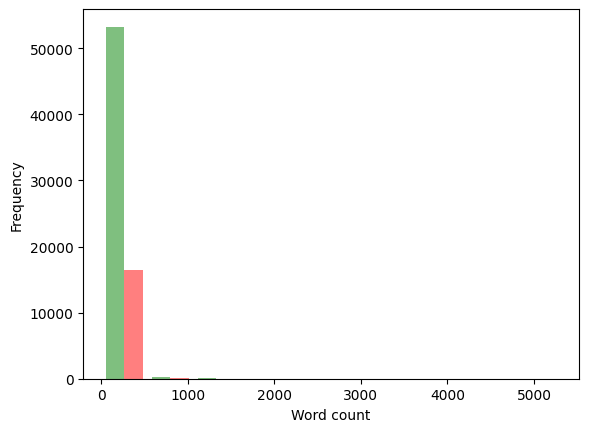

In [ ]:
# plot word count distribution for both positive and negative

data['word count'] = data['Reviews'].apply(word_count)
p = data['word count'][data.Rating == 1]
n = data['word count'][data.Rating == 0]
#plt.figure(figsize=(12,6))
#plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
#plt.legend(loc='upper right')

In [ ]:
# get common words in training dataset
from collections import Counter
all_words = []
for line in list(data['Reviews']):
    words = str(line).split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())

Counter(all_words).most_common(20)

[('the', 133284),
 ('and', 76367),
 ('phone', 55235),
 ('this', 40124),
 ('for', 35273),
 ('with', 29170),
 ('not', 27623),
 ('was', 27406),
 ('that', 23756),
 ('but', 23728),
 ('have', 19195),
 ('you', 18199),
 ('very', 15634),
 ('good', 13925),
 ('great', 13400),
 ('had', 11510),
 ('like', 10173),
 ('phone.', 9998),
 ('just', 9510),
 ('from', 9409)]

# Data Processing <a id="4"></a>

In [ ]:
%matplotlib inline
# sns.countplot(data['Rating'])

In [ ]:
# Removing the unnecessary columns.
data.drop(['Product Name','Brand Name',	'Price','Review Votes'], axis=1, inplace=True)

In [ ]:
data.drop('word count', axis=1, inplace=True)

In [ ]:
data.head(10)

,Rating,Reviews
196581,1,I love this phone! I just upgraded from a Moto...
177357,1,Did exactly what I wanted it to do. At work or...
127074,1,Just received the phone so far so good. One th...
162800,1,Perfect.
332916,1,I really like this phone meets my expectations...
392292,1,"Phone is great, unlike US version has fingerpr..."
360767,1,great phone as for now perfect!!...thanx
81746,1,"excellent phone, especially for the price. doe..."
11552,1,love it...
413679,1,My purchase of a used Verizon Samsung U640 was...


In [ ]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

,0
Rating,0.000000
Reviews,0.015714


In [ ]:
#convrting pandas object to a string type
data['Reviews'] = data['Reviews'].astype('str')

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{'being', 'do', 'when', 'can', 'i', 'them', 'his', 'me', 'other', 'whom', "needn't", 'that', 'am', 'be', 'very', 'once', 'again', 'few', 'hasn', 'themselves', 'we', 'the', 'has', 'for', 'any', 'about', 'himself', 'hadn', "couldn't", 'ours', 'y', 'don', 'out', 'only', 'herself', 'are', 'hers', 'where', 'on', 'my', 'shouldn', 'to', 'up', 'aren', "don't", "shouldn't", 'you', 'over', 'he', 'should', 'below', "should've", "shan't", 'shan', 'some', 'same', 'own', 'all', 'yourself', 'doesn', 'above', 'having', 'yourselves', 'nor', 'why', 'and', 'd', 'too', 'a', 'because', "doesn't", 'now', 'does', 'not', 'an', 'o', 'mustn', 'those', 'such', 'didn', 'itself', 'at', 'wasn', "you're", 'so', "hasn't", 'from', 'into', 'myself', 'how', 'your', 'yours', 'further', 'ourselves', 'they', 'which', 'mightn', 'these', 'won', 'off', 'her', 'was', 't', "haven't", 'wouldn', 'until', 'but', "hadn't", 'most', 'against', 'their', 'after', 'here', 'in', 'under', 'what', 'have', 'm', "isn't", 'haven', 'did', 'jus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
data['processed_tweets'] = data['Reviews'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
data.head(10)

,Rating,Reviews,processed_tweets
196581,1,I love this phone! I just upgraded from a Moto...,love phone upgraded moto still mind blown thin...
177357,1,Did exactly what I wanted it to do. At work or...,id exactly wanted work anywhere dont want carr...
127074,1,Just received the phone so far so good. One th...,ust received phone far good one thing phone qu...
162800,1,Perfect.,erfect
332916,1,I really like this phone meets my expectations...,really like phone meet expectation thing like ...
392292,1,"Phone is great, unlike US version has fingerpr...",hone great unlike u version fingerprint scanne...
360767,1,great phone as for now perfect!!...thanx,reat phone perfectthanx
81746,1,"excellent phone, especially for the price. doe...",xcellent phone especially price lag snappy cam...
11552,1,love it...,ove
413679,1,My purchase of a used Verizon Samsung U640 was...,purchase used verizon samsung u640 good invest...


### Word-Cloud for Negative tweets.

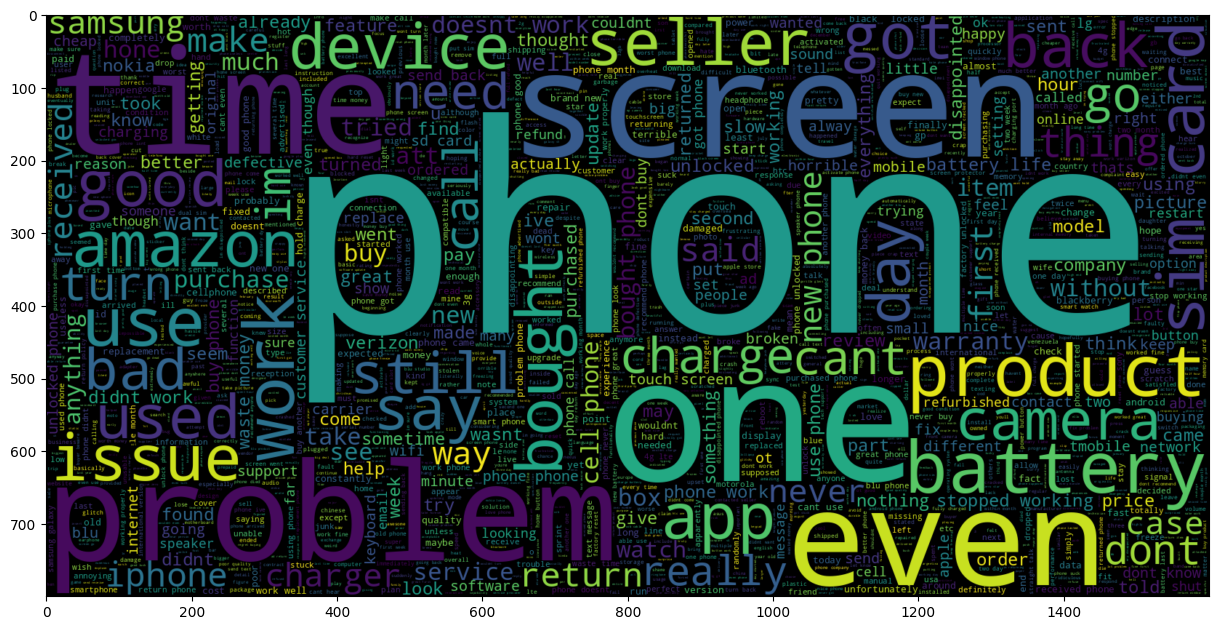

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Rating == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

### Word-Cloud for Positive tweets.

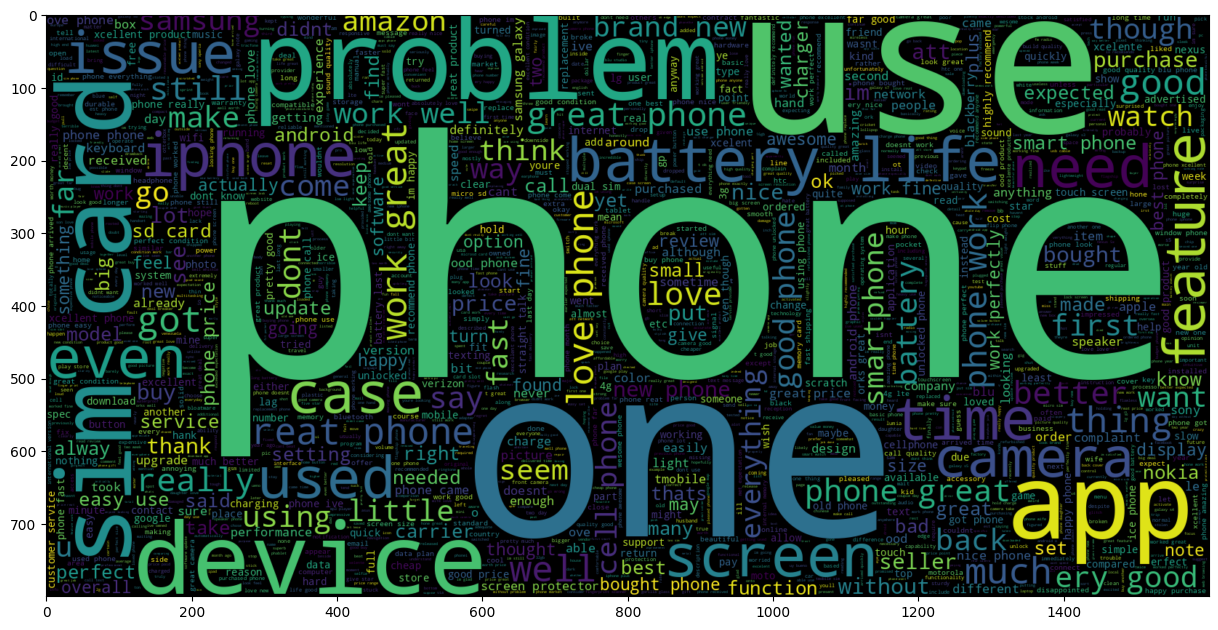

In [ ]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Rating == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

## Vectorization and Splitting the data <a id="6"></a>
Storing input variable-processes_tweets to X and output variable-polarity to y

In [ ]:
X = data['processed_tweets'].values
y = data['Rating'].values

In [ ]:
print(X.shape)
print(y.shape)

(70000,)
(70000,)


In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names_out()))

Vector fitted.
No. of feature_words:  52506


In [ ]:
print(X.shape)
print(y.shape)

(70000, 52506)
(70000,)


## Split train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (56000, 52506)
y_train (56000,)

X_test (14000, 52506)
y_test (14000,)


# Model Building <a id="7"></a>

### Model evaluating function

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)

    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Random Forest <a id="10"></a>

Accuracy of model on training data : 85.57321428571429
Accuracy of model on testing data : 81.8 

              precision    recall  f1-score   support

           0       0.93      0.25      0.39      3296
           1       0.81      0.99      0.89     10704

    accuracy                           0.82     14000
   macro avg       0.87      0.62      0.64     14000
weighted avg       0.84      0.82      0.77     14000



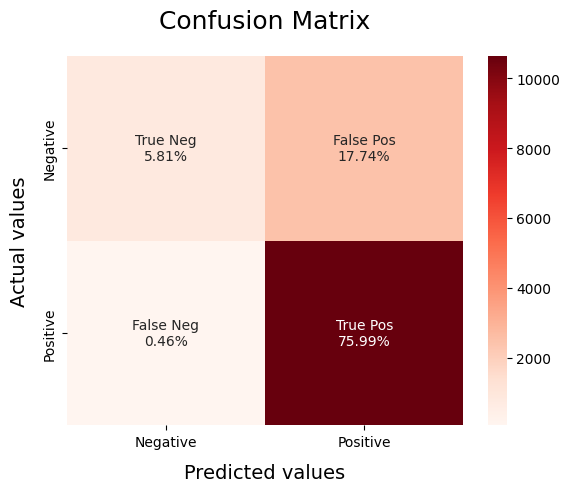

In [ ]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

### Naive Bayes <a id="11"></a>

Accuracy of model on training data : 83.14642857142857
Accuracy of model on testing data : 81.10000000000001 

              precision    recall  f1-score   support

           0       0.63      0.47      0.54      3296
           1       0.85      0.92      0.88     10704

    accuracy                           0.81     14000
   macro avg       0.74      0.69      0.71     14000
weighted avg       0.80      0.81      0.80     14000



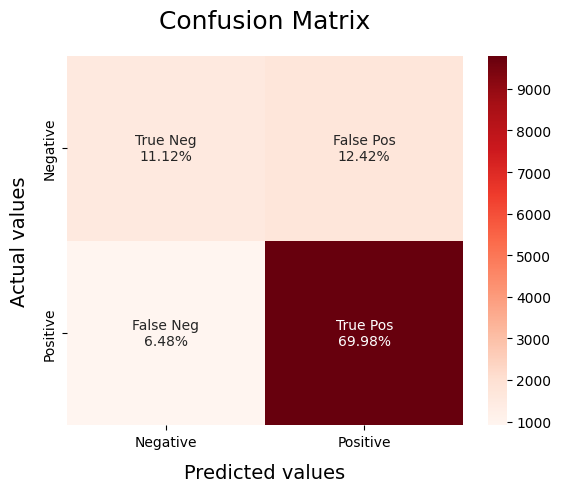

In [ ]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)

# RNN <a id="12"></a>

In [66]:
import keras
keras.__version__

'3.4.1'

In [67]:
!pip install Keras-Preprocessing

In [68]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import re

In [69]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    1   75  117]
 [   0    0    0 ...    1   88    8]
 [   0    0    0 ...   44 1011  138]
 ...
 [   0    0    0 ...  118 1425    1]
 [   0    0    0 ...   75  179   71]
 [   0    0    0 ...   86   71  124]]


In [70]:
X_train, X_test, y_train, y_test = train_test_split(tweets, data.Rating.values, test_size=0.2, random_state=101)

In [71]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [72]:
def model_Evaluate1(model):
    y_pred = model.predict(X_test)
    # Convert the predicted probabilities to class labels
    y_pred_classes = (y_pred > 0.5).astype(int)  # Modify the threshold as needed for your problem

    # Get the confusion matrix
   # confusion = confusion_matrix(y_test, y_pred_classes)

    cf_matrix = confusion_matrix(y_test, y_pred_classes)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)
    # Get the classification report
    report = classification_report(y_test, y_pred_classes)

    print("Confusion Matrix:")
    print(cf_matrix)

    print("\nClassification Report:")
    print(report)


In [73]:
# model_Evaluate1(model2)

In [77]:
def fitness_func(features):

    if len(features) == 0:
        return (0, 0)

    X_train_selected = X_train[:, features]
    X_test_selected = X_test[:, features]
    model2 = Sequential()
    model2.add(layers.Embedding(max_words, 128))
    model2.add(layers.LSTM(64,dropout=0.5))
    model2.add(layers.Dense(16, activation='relu'))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(1,activation='sigmoid'))
    model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    checkpoint2 = ModelCheckpoint("rnn_model.keras", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
    history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])
    loss,accuracy = model2.evaluate(X_test,y_test)
    num_selected_features = len(features)
    return (accuracy, num_selected_features)

In [78]:
# Define the Spider Monkey Optimization algorithm
def smo(num_spiders, max_iterations, q, alpha, beta, gamma):
    spiders = np.random.rand(num_spiders, X_train.shape[1])
    fitness = np.zeros(num_spiders)
    best_fitness = -np.inf
    best_features = None
    for i in range(num_spiders):

        fitness[i], _ = fitness_func(np.where(spiders[i] > 0.2)[0])
        if fitness[i] > best_fitness:
            best_fitness = fitness[i]
            best_features = np.where(spiders[i] > 0.2)[0]
    for t in range(max_iterations):
        for i in range(num_spiders):
            distances = np.linalg.norm(spiders - spiders[i], axis=1)
            attraction = np.zeros(X_train.shape[1])
            repulsion = np.zeros(X_train.shape[1])
            for j in range(num_spiders):
                if i != j:
                    if fitness[j] > fitness[i]:
                        attraction += beta * (spiders[j] - spiders[i]) / distances[j]**q
                    elif distances[j] != 0:
                        repulsion += gamma * (spiders[i] - spiders[j]) / distances[j]**q
            velocity = alpha * (attraction + repulsion)
            spiders[i] += velocity
            spiders[i] = np.clip(spiders[i], 0, 1)
            new_fitness, _ = fitness_func(np.where(spiders[i] > 0.2)[0])
            if new_fitness > fitness[i]:
                fitness[i] = new_fitness
                if new_fitness > best_fitness:
                    best_fitness = new_fitness
                    best_features = np.where(spiders[i] > 0.2)[0]
    return best_features


In [79]:
best_features = smo(num_spiders=1, max_iterations=1, q=1, alpha=0.1, beta=1, gamma=2)

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8269 - loss: 0.4140
Epoch 1: val_accuracy improved from -inf to 0.90429, saving model to rnn_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 231s 130ms/step - accuracy: 0.8270 - loss: 0.4139 - val_accuracy: 0.9043 - val_loss: 0.2346
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9133 - loss: 0.2171
Epoch 2: val_accuracy improved from 0.90429 to 0.91100, saving model to rnn_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 232s 132ms/step - accuracy: 0.9133 - loss: 0.2171 - val_accuracy: 0.9110 - val_loss: 0.2196
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9247 - loss: 0.1924
Epoch 3: val_accuracy did not improve from 0.91100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 258s 130ms/step - accuracy: 0.9247 - loss: 0.1924 - val_accuracy: 0.9098 - val_loss: 0.2209
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9329 - loss: 0.1745
Epoch 4: val_accuracy improved from 0.91100 to 

In [82]:
def evaluate_fitness(features):
    # Extract selected features from the training and testing sets

    if len(features) == 0:
    # Return a default fitness value.
        return (0, 0)

    X_train_selected = X_train[:, features]
    X_test_selected = X_test[:, features]
    model2 = Sequential()
    model2.add(layers.Embedding(max_words, 128))
    model2.add(layers.LSTM(64,dropout=0.5))
    model2.add(layers.Dense(16, activation='relu'))
    model2.add(layers.Dense(8, activation='relu'))
    model2.add(layers.Dense(1,activation='sigmoid'))
    model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    checkpoint2 = ModelCheckpoint("rnn_model.keras", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_weights_only=False)
    history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])
    loss,accuracy = model2.evaluate(X_test,y_test)
    model_Evaluate1(model2)
    # Calculate the number of selected features
    num_selected_features = len(features)
    # Return the fitness value as a tuple
    return (accuracy, num_selected_features,model2,history)

Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8535 - loss: 0.3385
Epoch 1: val_accuracy improved from -inf to 0.90521, saving model to rnn_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 237s 133ms/step - accuracy: 0.8535 - loss: 0.3385 - val_accuracy: 0.9052 - val_loss: 0.2339
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9142 - loss: 0.2126
Epoch 2: val_accuracy improved from 0.90521 to 0.90950, saving model to rnn_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 262s 133ms/step - accuracy: 0.9142 - loss: 0.2126 - val_accuracy: 0.9095 - val_loss: 0.2178
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9262 - loss: 0.1856
Epoch 3: val_accuracy improved from 0.90950 to 0.91186, saving model to rnn_model.keras
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 260s 132ms/step - accuracy: 0.9262 - loss: 0.1856 - val_accuracy: 0.9119 - val_loss: 0.2207
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9324 - loss: 0.1684
Epoch 4: v

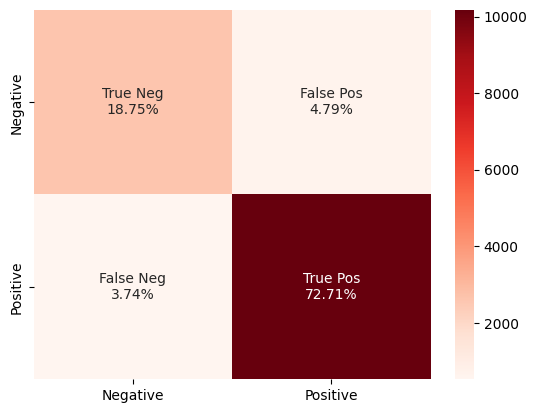

In [83]:
accuracy, num_selected_features,model,history = evaluate_fitness(best_features)

print("Selected features:", best_features)
print("Accuracy:", accuracy)
print("Number of selected features:", num_selected_features)

In [84]:
result_dict = history.history
result_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [85]:
result_dict

{'accuracy': [0.8830178380012512,
  0.9135714173316956,
  0.9234821200370789,
  0.9317142963409424,
  0.9371964335441589,
  0.9451071619987488,
  0.9495893120765686,
  0.9550714492797852,
  0.9587143063545227,
  0.9626071453094482],
 'loss': [0.2789548635482788,
  0.21266970038414001,
  0.1904422640800476,
  0.17083200812339783,
  0.15858380496501923,
  0.14200446009635925,
  0.13182014226913452,
  0.11966650187969208,
  0.11046726256608963,
  0.1019926443696022],
 'val_accuracy': [0.9052143096923828,
  0.909500002861023,
  0.9118571281433105,
  0.9137142896652222,
  0.9137856960296631,
  0.9153571724891663,
  0.9129999876022339,
  0.902571439743042,
  0.9126428365707397,
  0.914642870426178],
 'val_loss': [0.23388652503490448,
  0.21783822774887085,
  0.22066691517829895,
  0.2229917347431183,
  0.22582975029945374,
  0.2275564968585968,
  0.2429584264755249,
  0.2707214653491974,
  0.2594355046749115,
  0.27456122636795044]}

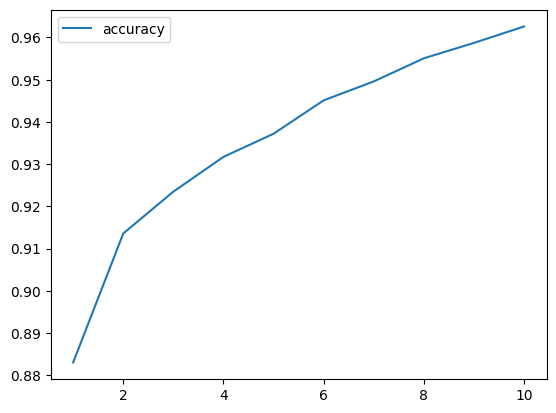

In [86]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,len(result_dict['accuracy'])+1), result_dict['accuracy'], label="accuracy")
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [88]:
def precision_recall_f1_score(true_labels, pred_labels):

  threshold = 0.5
  pred_labels = [1 if score >= threshold else 0 for score in pred_labels]
  accuracy_value = accuracy_score(true_labels, pred_labels)
  precision_value = precision_score(true_labels, pred_labels)
  recall_value = recall_score(true_labels, pred_labels)
  f1_score_value = f1_score(true_labels, pred_labels)

  print('Acuuracy =',accuracy_value)
  print('Precision =',precision_value)
  print('Recall =',recall_value)
  print('F1 Score =',f1_score_value)

In [89]:
X_train_prediction = model.predict(X_train)

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 77s 44ms/step


In [90]:
precision_recall_f1_score(y_train, X_train_prediction)

Acuuracy = 0.9773035714285714
Precision = 0.9813884580661589
Recall = 0.9891045681489431
F1 Score = 0.9852314056308897


In [91]:
X_test_prediction = model.predict(X_test)

438/438 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step


In [92]:
precision_recall_f1_score(y_test, X_test_prediction)

Acuuracy = 0.9146428571428571
Precision = 0.9381623813473413
Recall = 0.9510463378176383
F1 Score = 0.9445604268151242


In [93]:
sequence = tokenizer.texts_to_sequences(['Good product'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Positive


In [95]:
model = keras.models.load_model('rnn_model.keras')
sequence = tokenizer.texts_to_sequences(['Best phone in  this price'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Positive


In [96]:
sequence = tokenizer.texts_to_sequences(['I reviced a used product.'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Positive
